<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: SkimLit 🔥
### We will be replicating the deep learning model behind the 2017 paper [PubMed: A Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

**The Problem:** The number of RCT papers releases is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature

**The Solution:** Create a NLP model to classify abstract sentences into the role they play from the list of possible roles (objective, method, result, background or conclusion)

The data comes from: [PubMed: A Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

The model is from: [Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)


### Steps to follow
1. Download the data
2. Perform Pre-processing
3. Create a baseline model

## 1. Dowload the data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.86 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


We will use the dataset `PubMed_20k_RCT_numbers_replaced_with_at_sign` for faster iterations on smaller data size. The `PubMed_200k_RCT_numbers_replaced_with_at_sign` is superset of `PubMed_20k_RCT_numbers_replaced_with_at_sign` where all the numbers (numerical values) are replaced with `at-sign`

In [2]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


**dev.txt**: Validation dataset

**train.txt**: Training dataset

**test.txt**: Test dataset

In [3]:
import os
# Lets turn the filepath and the filename to a variable
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# List all the files in a directory
filenames= [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

```
Visualize, Visualize, Visualize
```

In [4]:
# A function to read lines of a target file
from typing import List

def read_lines(filename) -> List[str]:
  """
    Reads a file and returns the lines of the file as list
    Args:
      filename(str): Name of the file
    Returns(List[str]):
      A list containing the lines in the file
  """
  with open(filename,"r") as f:
    return f.readlines()

In [5]:
train_text = read_lines(data_dir+"train.txt")
train_text[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Observations from reading the content of `train.txt`
1. Each sentence is prefixed with _role_ and separated by (`\t`) from the content of the sentence.
2. Each sentence ends with (`\n`) and a comma (`,`)
3. Every abstract is separated by abstract Id which starts with three hash (`###`) followed by a number and ends with (`\n`) and comma (`,`)
4. Every abstract ends with (`\n`) in a line

We will have to write a function such that all the lines in the target file are returned as list of dictionaries containing key/value pairs:
  
  * `"line_number"`: the position of the line in the abstract
  * `"target"`: the role of the line in the abstract
  * `"text"`: the text of the line in the abstract
  * `"total_lines"`: the total lines in an abstract sample

  Example output for a single line in an abstract
  ```
  [
    {
      "line_number":3
      ,"target": "OBJECTIVE"
      ,"text":"It was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood ."
      ,"total_lines": 11
    }
    ,{

    }
  ]  
  ```

In [6]:
from typing import Dict,List
def preprocess_text_with_line_numbers(filename) -> List[Dict]:
  """
    Takes a filename and returns the contents of the file as list of dictionaries.
    Args:
      filename(str): The name of the target file
    Returns:
      abstract_lines(List[Dict]): A list of dictionaries each containing a line from the abstract.
      Example output:
        [
          {
            "line_number":3
            ,"target": "OBJECTIVE"
            ,"text":"It was expected that emotional eating is predictive of elevated attention for food and higher food intake after an experimentally induced sad mood and that attentional maintenance on food predicts food intake during a sad versus a neutral mood ."
            ,"total_lines": 11
          }
          ,{
            "line_number":4
            ,"target": "BACKGROUND"
            ,"text":"Emotional eating is associated with overeating and the development of obesity ."
            ,"total_lines": 13
          }
        ]
  """
  # all_abstracts = []
  # abstract_line=""
  # file_content = read_lines(filename)
  # line_number = 0
  # abstract_line = {}
  # for line in file_content:
  #   # Check if the line contains abstract id
  #   if line.startswith("###"):
  #     abstract_id = line
  #   elif line in ['\n']:
  #     abstract_line["total_lines"] = line_number-1
  #     all_abstracts.append(abstract_line)
  #     line_number = 0
  #     abstract_line = {}
  #   else:
  #     target,text = line.split("\t")
  #     line_number += 1
  #     abstract_line["line_number"] = line_number
  #     abstract_line["target"] = target
  #     abstract_line["text"] = text
  # return all_abstracts
  input_lines = read_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [7]:
all_abstracts=preprocess_text_with_line_numbers(data_dir+"train.txt")

In [8]:
len(all_abstracts)

180040

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples),len(test_samples)

CPU times: user 640 ms, sys: 113 ms, total: 754 ms
Wall time: 1.79 s


(180040, 30212, 30135)

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
len(train_df),len(val_df), len(test_df)

(180040, 30212, 30135)

In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

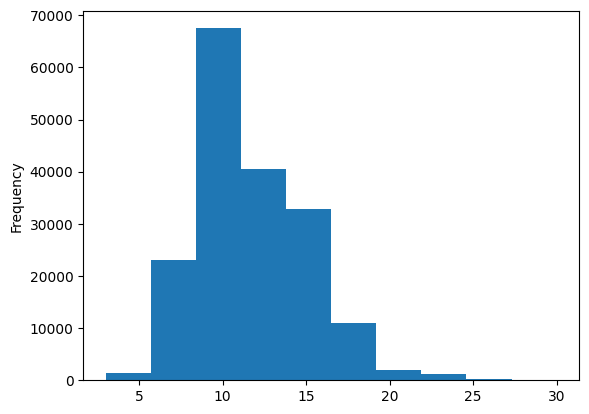

In [13]:
train_df.total_lines.plot.hist();

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

### Make numerical labels
We're going to create one hot and label encoded labels
> We could get away with just making label encoded labels, however, Tensorflow's CategoricalCrossEntropy loss function likes to have one hot encoded labels

In [15]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
## Extract labels ( targets ) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [18]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
classes = label_encoder.classes_
num_classes,classes

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline
Our first model will be a Tf-Idf Multinomial Naive Bayes as recommended by [Scikit-Learn's Machine Learning map](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-0-getting-a-baseline)

To build it we will use Scikit-Learn's `pipeline` which use `TfidfVectorizer` class to convert our abstract sentences into numbers using TF-IDF (term frequency- inverse document frequency) algorithm and then learn's to classify the sentence using `MultinomialNB` algorithm

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer())
    ,("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences
              ,y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

We need to define a function to calculate the following model metrics
1. Accuracy
2. Precision
3. Recall
4. f1-score

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from typing import Dict
def calculate_results(y_true,y_pred)-> Dict:
  """
    Calculate the model evaluation metrics, namely : accuracy, precision, recall, fscore
    Args:
      y_true(List[Any]): True labels
      y_pred(List[Any]): Predicted labels
    Returns:
      model_results(Dict)
  """
  accuracy = accuracy_score(y_true=y_true,y_pred=y_pred) * 100
  # calculate the precision, recall and f1_score using the "weighted" average
  precision,recall,f1_score,_ = precision_recall_fscore_support(y_true=y_true,y_pred=y_pred,average="weighted")
  model_results = {
      "accuracy":accuracy
      ,"precision":precision
      ,"recall":recall
      ,"f1score":f1_score
  }
  return model_results


In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1score': 0.6989250353450294}

### Preparing the data from deep sequence models
Before we embark on the journey of creating model, we will have to _numericalize_ our data using text vectorizer and embedding layers. Hence, we will have to create our own **text vectorizer** and **embedding layer**

In [25]:
# import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since, we will be dealing with text, its a good practice to find out the length of each line to be used for training.
> _In general, neural networks works best when the inputs are of the same size. This is important as it will be used to create batches of same size
For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as 29 words sentence_.

In [26]:
#Let's find the average length of sentences in our training set
sentence_lengths = [len(sentence.split()) for sentence in train_sentences ]
avg_len = sum(sentence_lengths)/len(train_sentences)
avg_len

26.338269273494777

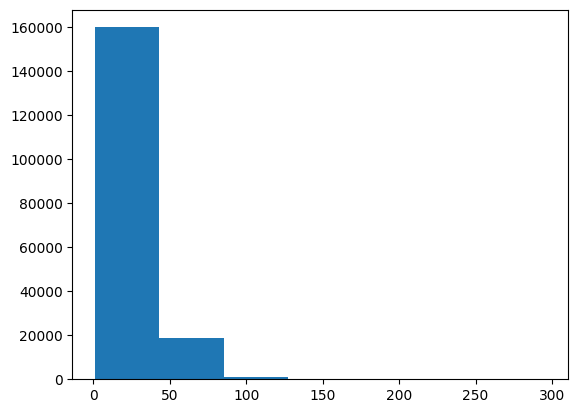

In [27]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths,bins=7);

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentence_lengths,95))
output_seq_len

55

> **🔑Note**: Good practices to be followed when working with text corpus for a NLP problem
1. What is the length of longest text?
2. What is the length of smallest text?
3. What is the distribution of length of text?
4. One-hot encode the target labels
5. LabelEncode the target labels


In [29]:
# As mentioned in Table.1
max_tokens=68000
#Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens
                                 ,output_sequence_length=55) ## 55 since, we saw that 95% percent of lines in abstract are of length 55

# adapt text vectorizer to training data

text_vectorizer.adapt(train_sentences)


In [30]:
# Test our text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"Length of text:\n {len(target_sentence.split())}")
print(f"Vectorized Text:\n {text_vectorizer([target_sentence])}")

Text:
 robust clinical data evaluating fibrosis progression in hepatitis c virus ( hcv ) liver transplant patients receiving an mtor inhibitor vs. calcineurin inhibitor ( cni ) are lacking .
Length of text:
 29
Vectorized Text:
 [[ 2485    47   100  1556  1938   499     5  1363   243  1308  1446   604
   1506    12   245    26 10667   738    44 10434   738  5770    58  2563
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding
Our `text_vectorization` layers maps the words in our text directly to numbers.However, this doesn't capture the context of the sentence or in other words relation between the numbers

To create richer numerical representation of our text, we need to use **embedding**

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationship between tokens (numbers) in our corpus, hence will be able to gain the context of the sentences.

We can create trainable embeddings using Tensorflow's `Embedding` layer.

Again, here we are concerned about the input and output parameters of our `Embedding` layer.

The `input_dim` describes the vocabulary size (68K in our case). And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the output of `text_vectorization` as input and convert them into feature vector of size `output_dim`

In [32]:
# Create token embedding layer
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab)
                               ,output_dim=128
                               ,mask_zero=True
                               ,name="model_0_embedding"
                               )

print(f" Sentence before vectorization:{target_sentence}")
vectorized_text = text_vectorizer([target_sentence])
print(f" Sentence after vectorization before embedding: {vectorized_text}")
trainable_embeddings = token_embed(vectorized_text)
print(f" Sentence after  embedding: {trainable_embeddings}")

 Sentence before vectorization:robust clinical data evaluating fibrosis progression in hepatitis c virus ( hcv ) liver transplant patients receiving an mtor inhibitor vs. calcineurin inhibitor ( cni ) are lacking .
 Sentence after vectorization before embedding: [[ 2485    47   100  1556  1938   499     5  1363   243  1308  1446   604
   1506    12   245    26 10667   738    44 10434   738  5770    58  2563
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
 Sentence after  embedding: [[[-0.01480681  0.0470917   0.02731249 ... -0.04013614  0.01418686
   -0.03911931]
  [ 0.02049926 -0.04197872  0.01516047 ... -0.01785673 -0.02052203
   -0.03161614]
  [-0.00143947  0.00714611  0.02545947 ...  0.01745364  0.01828488
   -0.03487778]
  ...
  [-0.01974588 -0.02552342 -0.04784456 ...  0.00300359 -0.00867044
   -0.01223784]
  [-0.01974588 -0.02552342 -0

In [33]:
from datetime import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  """
    This function is used as a callback during the training of a model.
    This will store the training experiments as we iterate over various strategies of
    building / training the model
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## Create Datasets

In [34]:
len(train_sentences),len(val_sentences)

(180040, 30212)

In [35]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset= tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings
All our deep learning models will have a similar structure
```
Text(input) -> Tokenize -> Embedding -> Layers -> Output (Label Probabilities)
```

In [37]:
# Create a 1D convolutional model to process sentences
inputs= layers.Input(shape=(1,),dtype=tf.string)
text_vectors= text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
print(f"Shape of embedding tokens: {token_embeddings.shape}")
x= layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x= layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(num_classes,activation="softmax")(x)
model_1= tf.keras.Model(inputs,outputs,name="conv1d")

model_1.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

model_1.summary()

Shape of embedding tokens: (None, 55, 128)
Model: "conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 model_0_embedding (Embeddin  (None, 55, 128)          8299648   
 g)                                                              
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                 

Before we fit the model, let us create a function to push save our model experiments so that we can visualize it later on a tensorboard

In [38]:
SAVE_DIR="model_log"

In [39]:
history_1 = model_1.fit(train_dataset
                        ,steps_per_epoch=int(0.1 * len(train_dataset))
                        ,validation_data=val_dataset
                        ,validation_steps=int(0.1*len(val_dataset))
                        ,epochs=5
                        ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1_con1D")]
                        )

Epoch 1/5
562/562 [==============================] - 55s 75ms/step - loss: 0.9127 - accuracy: 0.6387 - val_loss: 0.6808 - val_accuracy: 0.7420
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6543 - accuracy: 0.7584 - val_loss: 0.6319 - val_accuracy: 0.7699
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6152 - accuracy: 0.7762 - val_loss: 0.5956 - val_accuracy: 0.7846
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5876 - accuracy: 0.7881 - val_loss: 0.5770 - val_accuracy: 0.7862
Epoch 5/5
562/562 [==============================] - 5s 10ms/step - loss: 0.5889 - accuracy: 0.7929 - val_loss: 0.5615 - val_accuracy: 0.7942


In [40]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5604 - accuracy: 0.8005


[0.560358464717865, 0.800476610660553]

In [41]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.63232183e-01, 1.56213984e-01, 4.96241413e-02, 1.83785751e-01,
        4.71438952e-02],
       [4.43312079e-01, 3.53398651e-01, 2.52235532e-02, 1.37445956e-01,
        4.06198725e-02],
       [1.64108813e-01, 3.34842922e-03, 1.01554731e-03, 8.31487775e-01,
        3.94450144e-05],
       ...,
       [3.71022907e-05, 7.32677581e-04, 4.90470557e-03, 3.22001288e-05,
        9.94293332e-01],
       [1.02900214e-01, 2.61818856e-01, 1.77991882e-01, 7.57397264e-02,
        3.81549329e-01],
       [1.74848020e-01, 7.35770881e-01, 5.30318394e-02, 1.37440944e-02,
        2.26051547e-02]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded
                                    ,y_pred=model_1_preds)
model_1_results

{'accuracy': 80.0476631801933,
 'precision': 0.8008454558925686,
 'recall': 0.800476631801933,
 'f1score': 0.797301817061669}

## Model 2: Feature extraction with pretrained token embeddings
As we move towards replicating the model architecture in [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf), it mentions they have used a [pretrained GLoVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

For our learning purpose , we will use whatever is available from Tensorflow hub. [GLoVe embedding](https://nlp.stanford.edu/projects/glove/) is not available in Tensorflow hub, hence we will use [pretrained Universal Sentence Embedding from Tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder/4)

_This type of model is called **transfer learning**, or more specifically **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem_

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4"
                                        ,trainable=False
                                        ,name="universal_sentence_encoder")


In [45]:
random_training_sentence= random.choice(train_sentences)
print(f" Training sample sentence: {random_training_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f" Shape of the embedding vector generated use Universal Sentence Encoder : {use_embedding_sentence.shape}")
print(f" Sentence embedding :{use_embedding_sentence[0][:30]}")
print(f" Length of sentence embedding: {len(use_embedding_sentence[0])}")

 Training sample sentence: all participants received best-evidence advice and were followed up for @ months .
 Shape of the embedding vector generated use Universal Sentence Encoder : (1, 512)
 Sentence embedding :[ 0.00484913 -0.03850516 -0.00225086 -0.03250641 -0.05450161 -0.02490935
  0.07462091 -0.02225216 -0.09866872 -0.02514302 -0.04585677 -0.00263409
  0.03240417  0.04591604 -0.04646168  0.07207243  0.05074014  0.00342012
 -0.03480062 -0.01584869 -0.04636295  0.08067328 -0.06760173  0.002409
 -0.0411352   0.01931971 -0.0176773  -0.02203086  0.03911119  0.04047157]
 Length of sentence embedding: 512


  Building and fitting an NLP feature extraction model from Tensorflow hub

In [46]:
# Define feature extraction model from Tensorflow hub
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="feature_extraction_model_2")

model_2.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

model_2.summary()

Model: "feature_extraction_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
history_2 = model_2.fit(train_dataset
                        ,steps_per_epoch=(0.1 * len(train_dataset))
                        ,validation_data=val_dataset
                        ,validation_steps=(0.1 * len(val_dataset))
                        ,epochs=5
                        ,callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="feature_extractor_model_2")]
                        )

Epoch 1/5
562/562 [==============================] - 13s 17ms/step - loss: 0.9192 - accuracy: 0.6463 - val_loss: 0.8023 - val_accuracy: 0.6839
Epoch 2/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7678 - accuracy: 0.7014 - val_loss: 0.7550 - val_accuracy: 0.7059
Epoch 3/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7496 - accuracy: 0.7133 - val_loss: 0.7373 - val_accuracy: 0.7161
Epoch 4/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7176 - accuracy: 0.7246 - val_loss: 0.7088 - val_accuracy: 0.7306
Epoch 5/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7234 - accuracy: 0.7240 - val_loss: 0.6901 - val_accuracy: 0.7352


In [48]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6972 - accuracy: 0.7353


[0.6972301602363586, 0.73533695936203]

In [49]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[6.8721920e-01, 1.9924329e-01, 2.3079638e-03, 1.0266798e-01,
        8.5616149e-03],
       [4.3741325e-01, 4.5283431e-01, 5.0233728e-03, 1.0265635e-01,
        2.0727064e-03],
       [4.0557674e-01, 6.7740083e-02, 5.5673253e-02, 4.2446455e-01,
        4.6545431e-02],
       ...,
       [1.9744367e-03, 1.9789769e-03, 7.6439410e-02, 6.1633985e-04,
        9.1899085e-01],
       [2.3068192e-03, 2.9492503e-02, 4.9126309e-01, 6.7521498e-04,
        4.7626236e-01],
       [1.5391941e-01, 3.7175339e-01, 4.3340978e-01, 2.1021622e-03,
        3.8815215e-02]], dtype=float32)

In [50]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 2])>

In [51]:
model_2_results = calculate_results(y_true=val_labels_encoded
                                    ,y_pred=model_2_preds)
model_2_results

{'accuracy': 73.53369522044221,
 'precision': 0.7318604794128377,
 'recall': 0.7353369522044221,
 'f1score': 0.7297724475568852}

## Model 3: Conv1D with character embeddings

 The [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) papers suggests use of a hybrid approach of character and token embeddings.

 **Character embedding** are generated using sequences split into characters whereas **token embedding** is created on sequences split into tokens

In [52]:
# A function to convert sentences into sequence of characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'a l l   p a r t i c i p a n t s   r e c e i v e d   b e s t - e v i d e n c e   a d v i c e   a n d   w e r e   f o l l o w e d   u p   f o r   @   m o n t h s   .'

We will have to create character-level datasets by splitting our sequence dataset into characters

In [53]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [54]:
# Average chars in training dataset
char_size = [len(sentence) for sentence in train_sentences]
avg = sum(char_size)/len(train_sentences)
avg

149.3662574983337

In [55]:
# What is the average number of characters that 95% for sentences have in our training dataset
output_seq_char_length = int(np.percentile(char_size,95))
output_seq_char_length

290

The whole idea of finding out the `output_seq_char_length` is to use the same value for `output_sequence_length` parameter while initializing `TextVectorization`

We will have to set `max_token` parameter value to a value such that it includes
1. Number of characters in english alphabet.
2. Number of digits
3. Number of punctuations
4. Out Of Vocabulary
5. Space character

In [56]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
NUM_CHARS_TOKEN = len(alphabet) +2
NUM_CHARS_TOKEN

70

In [58]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKEN
                                    ,output_sequence_length=output_seq_char_length
                                    ,standardize="lower_and_strip_punctuation"
                                    ,name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [60]:
# check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of different characters in character vocab: {len(char_vocab)}")
print(f" 5 most common characters : {char_vocab[:5]}")
print(f" 5 least common characters: {char_vocab[-5:]}")

 Number of different characters in character vocab: 28
 5 most common characters : ['', '[UNK]', 'e', 't', 'i']
 5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
